# State Reducers

As we know the default behaviour of a `State` is for every graph execution the parameters inside the `State` gets overriden. This is a problem when we want to have a track of user conversation which is required while developing chatbots.

## Without Reducers (Default overwriting State)

Let us try to create a simple graph with a State having just only one variable and analyse its behaviour.

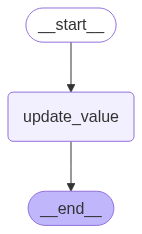

In [8]:
from typing import TypedDict

from langgraph.graph import StateGraph, START, END

# Defining State with one variable
class State(TypedDict):
    foo: int

# Defining a simple one node Graph
def node(state: State) -> str: 
    return {"foo": state["foo"] + 1} # incrementing the value by 1

# Defining a simple one node graph 
builder = StateGraph(State) 

builder.add_node("update_value", node)

builder.add_edge(START, "update_value") 
builder.add_edge("update_value", END)

graph = builder.compile()

graph

In [9]:
graph.invoke({ "foo" : 1 })

{'foo': 2}

As we see above, the value is getting overiden inside our state. pdated on its own. 

> Langgraph doesn't know the preferred way to update its State on its own. Hence the expected behaviour is the state variable gets overwritten for each graph execution.

## Branching 

Let us create a scenario where will try to create branches of nodes, and update the same variable.

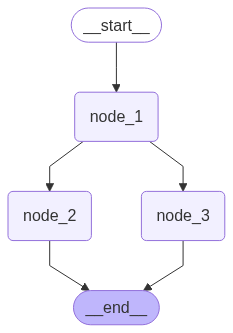

In [12]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

# Defining State with one variable
class State(TypedDict):
    foo: int

# Defining a simple three nodes Graph
def node_1(state: State) -> str: 
    print("__Node 1__")
    return {"foo": state["foo"] + 1} # incrementing the value by 1

def node_2(state: State) -> str: 
    print("__Node 2__")
    return {"foo": state["foo"] + 1} # incrementing the value by 1

def node_3(state: State) -> str: 
    print("__Node 3__")
    return {"foo": state["foo"] + 1} # incrementing the value by 1

# Defining a simple three nodes graph 
builder = StateGraph(State) 

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1") 
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

graph

In [13]:
from langgraph.errors import InvalidUpdateError 

try: 
    graph.invoke({ "foo" : 1 }) # passing data 
except InvalidUpdateError as e:
    print("You are not allowed to update the same state variable simultaneously in multiple nodes.")

__Node 1__
__Node 2__
__Node 3__
You are not allowed to update the same state variable simultaneously in multiple nodes.


**Observation:** 

Node 1 branches to Node 2 and Node 3. Hence, whenever the graph gets executed the control tries to update the State variable both at the same time. 

## Introducing Reducers

As we saw in the above cases, the default behaviour of State where its getting overwriten for every execuction.

Reducers are trying to solve this problem, where we will try to address this issue using pre-built reducers like `add` and `add_messages` in LangGraph. These needs to be `Annotated` to the main key, hence if any node attempts to update the value of the State, based on the reducer its going to work accordingly. 

### Using `add` reducer

Let us try using the same graph once again with a single node and use the add functionality, where we will add the new value after the execution.

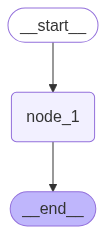

In [17]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END, add_messages

from operator import add

# Defining State with one variable
class State(TypedDict):
    foo: Annotated[list[int], add]

# Defining a simple node Graph
def node_1(state: State) -> str: 
    print("__Node 1__")
    return {"foo": [state["foo"][0] + 1]} # incrementing the value by 1

# Defining a simple node graph 
builder = StateGraph(State) 

builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1") 
builder.add_edge("node_1", END)

graph = builder.compile()

graph

In [19]:
graph.invoke({ "foo" : [4]})

__Node 1__


{'foo': [4, 5]}

### Using `add_messages` reducer

As we saw the functionality of `add` reducer, here it is basically adding any new value which was generated during the graph execution. 

Similarly, if we implement the same for storing the messages as well by creating `Annotated[list[BaseMessage], add]` this should be appending any new message generated in the graph execution. But, LangGraph supports Human-in-the-loop (HIL), if user wants to review any message in between or he modifies any then the modified one gets added as a new message since the message ID will be changed. 

To address this issue, `add_messages` reducers is built by LangGraph where its work is to update the messages if its completely new or if there was no message ID present already in the list, or else if the existing message got updated then it will only update the existing message and do not add a new message. 

By doing this, we are keeping the Messsages conversation intact and not making the conversation looks clumsy or irrelevant to the LLM.

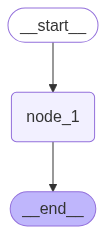

In [37]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END, add_messages
from operator import add

# Defining State with one variable
class State(TypedDict):
    foo: int 
    messages: Annotated[list[str], add] # using the add_messages reducer

# Defining a simple node Graph
def node_1(state: State) -> str: 
    print("__Node 1__")
    return {"messages": [state["messages"] + ["Adding"]]} # incrementing the value by 1

# Defining a simple node graph 
builder = StateGraph(State) 

builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1") 
builder.add_edge("node_1", END)

graph = builder.compile()

graph

In [38]:
graph.invoke({ "messages" : ["Hi there!"]})

__Node 1__


{'messages': ['Hi there!', ['Hi there!', 'Adding']]}